In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns
import matplotlib.transforms as mtrans
from collections import OrderedDict

/tmp/ipykernel_2264421/100516704.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
root_dir = "/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/"
models = {'Rotation': '2023-11-29/', 'Translation': '2024-01-17/'}
embeddings = 'dHCP_embeddings'
labels=['Preterm_28', 'Preterm_32', 'Preterm_37']
target = 'train_val_values.json'
metric = 'train_val_auc'

cols = ['Prematurity Class', 'Augmentation', 'AUC']
palette={'Rotation': 'darkred',
         'Translation': 'darkgreen'}

In [131]:
dict_values = {label : {key: [] for key in models.keys()} for label in labels}

In [132]:
for key, model in models.items():
    models_dirs = os.path.join(root_dir,model)
    for label in labels:
        selected_models_dirs = [root for root, dirs, files in os.walk(models_dirs)
                                    if (target in files) & (label in root) & ('best_model' not in root)]
        print(f'{label}, {key}: {selected_models_dirs}')
        values = []
        for directory in selected_models_dirs:
            with open(os.path.join(directory,target), 'r') as f:
                perf = json.load(f)
                value = perf[metric][0]
                values.append(value)
        dict_values[label][key]=values
        

Preterm_28, Rotation: ['/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_2/dHCP_embeddings/Preterm_28', '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_1/dHCP_embeddings/Preterm_28', '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/09-59-38_188/dHCP_embeddings/Preterm_28', '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_0/dHCP_embeddings/Preterm_28']
Preterm_32, Rotation: ['/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_2/dHCP_embeddings/Preterm_32', '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_1/dHCP_embeddings/Preterm_32', '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/09-59-38_188/dHCP_embeddings/Preterm_32', '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/15-49-36_0/dHCP_embeddings/Preterm_32']
Preterm_37, Rotation: ['/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Outp

In [133]:
df = pd.DataFrame([[k1, k2, elem] for k1, v1 in dict_values.items() for k2, list_val in v1.items() for elem in list_val], columns=cols)

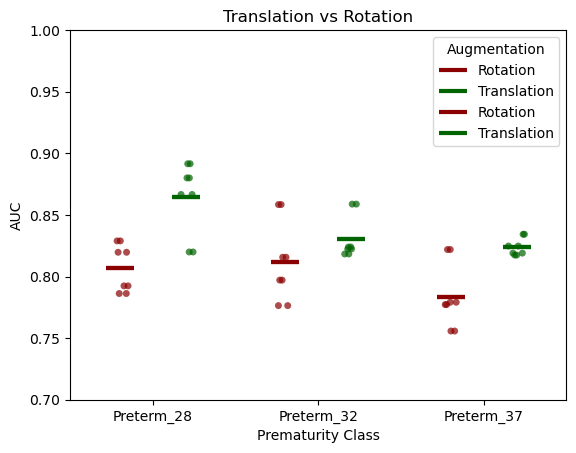

In [192]:
sns.stripplot(
data=df, x="Prematurity Class", y="AUC", hue="Augmentation",
dodge=True, alpha=.7, legend=False,
palette=palette
)
sns.pointplot(
    data=df, x="Prematurity Class", y="AUC", hue="Augmentation",
    dodge=.4, linestyle="none", errorbar=None,
    marker="_", markersize=20, markeredgewidth=3,
    palette=palette
)
#ax.set_title(side_name)
plt.ylim(0.7, 1)
plt.title('Translation vs Rotation')
plt.show()

In [193]:
# plot AUC depending on the learning rate
# use config diff

On peut changer le répertoire dans lequel on cherche les valeurs. Mais config diff ne va pas comparer les dates différentes : il faudrait créer un comparateur de config global ? C'est un peu compliqué... Voir WandB ?

In [23]:
models = '/volatile/jl277509/Runs/02_STS_babies/Program/Output/2024-01-26/'
df_configs = pd.read_csv(models+'config_diff.csv')
df_configs.columns = ['model'] + df_configs.columns.tolist()[1:]

label='Right_PCS'
target = 'train_val_values.json'
metric = 'train_val_auc'

In [24]:
# find existing perf directories
selected_models_dirs = [root for root, dirs, files in os.walk(models)
                            if (target in files) & (label in root) & ('best_model' not in root)]
directories = []
values = []
for idx, directory in enumerate(selected_models_dirs):
    with open(os.path.join(directory,target), 'r') as f:
        perf = json.load(f)
        value = perf[metric][0]
    directories.append(directory)
    values.append(value)

In [25]:
data = {'name': directories, 'value': values}
df_values = pd.DataFrame.from_dict(data)

In [26]:
values_configs = []
mod_names = []
for row in df_configs.iterrows():
    mod_name = row[1].model
    if df_values['name'].str.contains(mod_name + '/').sum() == 1:
        row = df_values[df_values['name'].str.contains(mod_name + '/')]
        val = row.value.tolist()[0]
        values_configs.append(val)
        mod_names.append(mod_name)

In [27]:
data = {'model': mod_names, 'value': values_configs}
df_values = pd.DataFrame.from_dict(data)

In [199]:
df = pd.merge(df_configs, df_values)

In [ ]:
# convert lr to str for stripplot
df['lr']=np.array(df['lr']).astype(str)

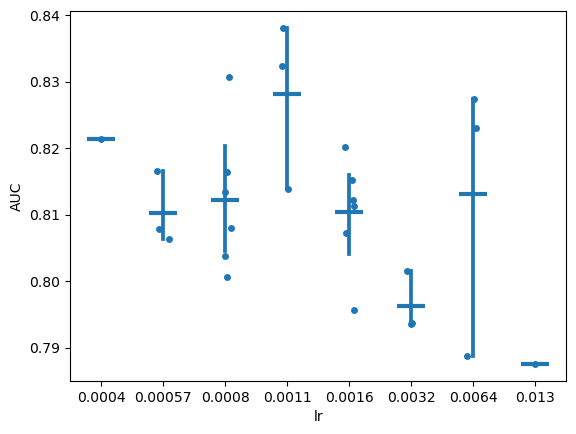

In [222]:
sns.stripplot(data=df, x='lr', y='value')
#plt.xscale('log')
sns.pointplot(
    data=df, x="lr", y="value",
    linestyle="none", errorbar=('ci', 95),
    marker="_", markersize=20, markeredgewidth=3)
plt.ylabel('AUC')
plt.show()

In [35]:
# retrieve the parameters manually when not present in config diff (parameters which were not added to parameters_to_keep...)
# trimdepth max_distance
data = {'model': ['19-06-17_0/', '16-33-55_0/', '19-06-17_1/', '16-33-55_1/', '19-06-17_2/', '16-33-55_2/', '13-09-40_156/', '16-33-55_3/', '19-06-17_3/', '16-33-55_4/', '19-06-17_4/', '16-33-55_4/'],
        'max_distance':range(0,12)}

In [36]:
models_dirs = '/volatile/jl277509/Runs/02_STS_babies/Program/Output/2024-01-31/'

In [37]:
x,y=[],[]
for model, max_dist in zip(data['model'], data['max_distance']):
    print(model, max_dist)
    x.append(max_dist)
    with open(models_dirs+model+'ACC_embeddings/Right_PCS/train_val_values.json', 'r') as f:
        auc = json.load(f)
    auc = auc['train_val_auc'][0]
    y.append(auc)

19-06-17_0/ 0
16-33-55_0/ 1
19-06-17_1/ 2
16-33-55_1/ 3
19-06-17_2/ 4
16-33-55_2/ 5
13-09-40_156/ 6
16-33-55_3/ 7
19-06-17_3/ 8
16-33-55_4/ 9
19-06-17_4/ 10
16-33-55_4/ 11


In [38]:
x.append(-1)
with open('/volatile/jl277509/Runs/02_STS_babies/Program/Output/2024-02-01/11-59-39_147/ACC_embeddings/Right_PCS/train_val_values.json', 'r') as f:
    auc = json.load(f)
    auc = auc['train_val_auc'][0]
    y.append(auc)

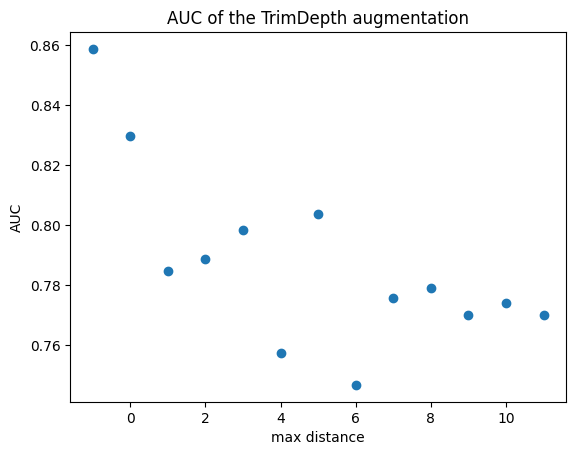

In [40]:
fig,ax = plt.subplots()
ax.scatter(x,y)
ax.set_xlabel('max distance')
ax.set_ylabel('AUC')
ax.set_title('AUC of the TrimDepth augmentation')
plt.show()

In [72]:
models_dirs = '/volatile/jl277509/Runs/02_STS_babies/Program/Output/1-5mm_embeddings_size/'
labels, colors, metrics, targets = ['Right_PCS','Age_64', 'Age', 'Sex'],\
                                   ['royalblue', 'darkorange', 'darkred', 'darkgreen'],\
                                   ['test_auc', 'train_val_auc', 'train_val_auc', 'train_val_auc'],\
                                   ['test_values.json', 'train_val_values.json', 'train_val_values.json', 'train_val_values.json']
#labels, colors, metric = ['Right_PCS','Age_64', 'Sex'],\
#                         ['royalblue', 'darkorange', 'darkgreen'],\
#                          'train_val_total_balanced_accuracy'
embeddings = ['ACC_custom_','UKB_5percent_','UKB_5percent_', 'UKB_5percent_']
# SVC regularization
#labels, colors, metric = ['Right_PCS', 'Right_PCS', 'Right_PCS', 'Right_PCS'],\
#                         ['royalblue', 'darkred', 'darkgreen', 'darkorange'] ,\
#                         'train_val_auc'
#embeddings = ['ACC_1_C0001', 'ACC_1_001', 'ACC_1_C01', 'ACC_1_C1']
#model_name = 'translation'
model_name = ''
df_list=[]
for label, embedding, metric, target in zip(labels, embeddings, metrics, targets):
    dict_values={}
    selected_models_dirs = [root for root, dirs, files in os.walk(models_dirs, followlinks=True)
                                if (target in files) & (root.endswith(label)) & (embedding+'embeddings' in root) & (model_name in root) & ('best_model' not in root)]
    lb = embedding+label
    print(f'{lb}: {selected_models_dirs}')
    dict_values = {'model': [], lb: []}
    for directory in selected_models_dirs:
        with open(os.path.join(directory,target), 'r') as f:
            perf = json.load(f)
            if isinstance(perf[metric], float):
                value = perf[metric]
            else:
                value = perf[metric][0]
            name = directory.replace(models_dirs, '').split('/')[0]
            dict_values['model'].append(name)
            dict_values[lb].append(value)
    df = pd.DataFrame.from_dict(dict_values)
    df_list.append(df)

ACC_custom_Right_PCS: ['/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/random_all_keep_top_3/ACC_custom_embeddings/Right_PCS', '/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/random_no_keep_no_translation_only_0/ACC_custom_embeddings/Right_PCS', '/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/random_no_keep_bs128_4/ACC_custom_embeddings/Right_PCS', '/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/foldlabel_cutout_no_keep_0/ACC_custom_embeddings/Right_PCS', '/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/random_no_keep_no_trimdepth_2/ACC_custom_embeddings/Right_PCS', '/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/random_no_keep_trimdepth_200_3/ACC_custom_embeddings/Right_PCS', '/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/random_all_keep_top_1/ACC_custom_embeddings/Right_PCS', '/volatile/jl277509/Runs/02_STS_babies/Program/Output/random/random_all_no_keep_0/ACC_custom_embeddings/Right_PCS', '/vo

In [73]:
df=pd.concat(df_list,axis=1).T.drop_duplicates().T
df=df.sort_values(by='model').reset_index(drop=True)
l=df['model'].tolist()
df['model']=['_'.join(elem.split('_')[0:-1]) for elem in l]

In [74]:
if 'UKB_5percent_Age_64' in df.keys():
    df['balanced_Age_64'] = (df[f'{embeddings[0]}Right_PCS'].to_numpy()+ np.minimum(np.ones(len(df['UKB_5percent_Age_64']))-df['UKB_5percent_Age_64'].to_numpy(),0.5)) / 2
    labels.append('balanced_Age_64')
    colors.append('goldenrod')
    embeddings.append('')
if 'UKB_5percent_Age' in df.keys():
    df['balanced_Age'] = (df[f'{embeddings[0]}Right_PCS'].to_numpy()+ np.minimum(np.ones(len(df['UKB_5percent_Age']))-df['UKB_5percent_Age'].to_numpy(),0.5)) / 2
    labels.append('balanced_Age')
    colors.append('red')
    embeddings.append('')
#df['balanced2'] = [(np.mean(df.loc[df['model']==model]['Right_PCS'].to_numpy())
#                   +np.mean(np.minimum(np.ones(len(df.loc[df['model']==model]))-df.loc[df['model']==model]['Age_64'].to_numpy(),0.5))
#                   -np.std(df.loc[df['model']==model]['Right_PCS'].to_numpy())
#                   -np.std(df.loc[df['model']==model]['Age_64'].to_numpy())
#)/2 for model in df['model'].tolist()]

plt.close()
fig, ax = plt.subplots(figsize=(15,10))
for idx, label in enumerate(labels):
    sns.violinplot(data=df, x='model', y=label, label=label, inner='point')
    sns.despine(offset=0, trim=False, ax=ax)
    #sns.stripplot(data=df, x='model', y=label, marker='v',ax=ax)
    #sns.pointplot(
    #    data=df, x="model", y=label,
    #    linestyles="", errorbar=None,
    #    marker="s", markersize=10, markeredgewidth=2,ax=ax,label=label,scale=1.2)
    plt.ylabel('AUC')
    #plt.xticks(rotation=15)
    offset = mtrans.ScaledTranslation(0.3*idx, 0, ax.figure.dpi_scale_trans)
    nb_coll = len(ax.collections)
    start_offset_idx, end_offset_idx = idx*nb_coll // len(labels), (idx+1)*nb_coll // len(labels)
    for k in range(start_offset_idx, end_offset_idx): #don't really understand the collection organization
        #first offset the points
        trans = ax.collections[k].get_transform()
        ax.collections[k].set_transform(trans + offset)
    #offset the errorbars
    offset = mtrans.ScaledTranslation(0.3*idx, 0, ax.figure.dpi_scale_trans)
    nb_lines = len(ax.lines)
    start_offset_idx, end_offset_idx = idx*nb_lines // len(labels), (idx+1)*nb_lines // len(labels)
    for k in range(start_offset_idx, end_offset_idx):
        trans = ax.lines[k].get_transform()
        ax.lines[k].set_transform(trans + offset)
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = OrderedDict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
#plt.legend()
plt.ylim(0.45,1)
plt.show()

/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_2264421/4259521861.py:9: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/volatile/jl277509/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_

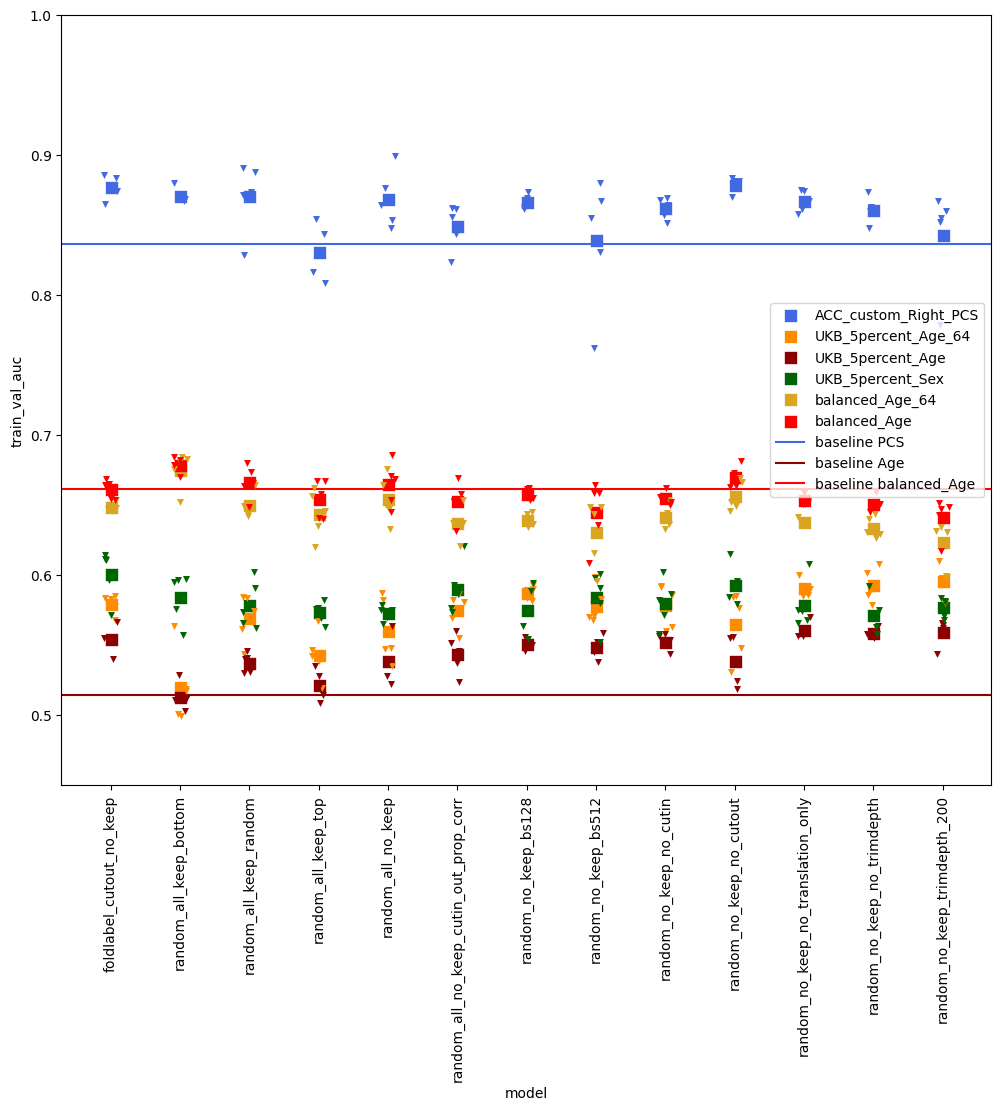

In [75]:
plt.close()
off=0
fig, ax = plt.subplots(figsize=(12,10))
for idx, (label, color, embedding) in enumerate(zip(labels, colors, embeddings)):
    #sns.violinplot(data=df, x='model', y=label, label=label, inner='point')
    #sns.despine(offset=0, trim=False, ax=ax)
    lb = embedding+label
    sns.stripplot(data=df, x='model', y=lb, marker='v',ax=ax, color=color)
    sns.pointplot(
        data=df, x="model", y=lb,
        linestyles="", errorbar=None,
        marker="s", markersize=10, markeredgewidth=2,ax=ax,label=lb,scale=1.2, color=color)
    plt.ylabel(metric)
    plt.xticks(rotation=90)
    offset = mtrans.ScaledTranslation(off*idx, 0, ax.figure.dpi_scale_trans)
    nb_coll = len(ax.collections)
    start_offset_idx, end_offset_idx = idx*nb_coll // len(labels), (idx+1)*nb_coll // len(labels)
    for k in range(start_offset_idx, end_offset_idx): #don't really understand the collection organization
        #first offset the points
        trans = ax.collections[k].get_transform()
        ax.collections[k].set_transform(trans + offset)
    #offset the errorbars
    offset = mtrans.ScaledTranslation(off*idx, 0, ax.figure.dpi_scale_trans)
    nb_lines = len(ax.lines)
    start_offset_idx, end_offset_idx = idx*nb_lines // len(labels), (idx+1)*nb_lines // len(labels)
    for k in range(start_offset_idx, end_offset_idx):
        trans = ax.lines[k].get_transform()
        ax.lines[k].set_transform(trans + offset)
plt.ylim(0.45,1)
if metric == 'train_val_auc':
    #plt.axline((0, 0.8257), (1, 0.8257), c='royalblue', label='baseline PCS')
    plt.axline((0, 0.8368), (1, 0.8368), c='royalblue', label='baseline PCS')
    plt.axline((0, 0.5147), (1, 0.5147), c='darkred', label='baseline Age')
    #plt.axline((0, 0.6555), (1, 0.6555), c='red', label='baseline balanced_Age')
    plt.axline((0, 0.6613), (1, 0.6613), c='red', label='baseline balanced_Age')

# DON'T USE
#elif metric == 'train_val_total_balanced_accuracy':
#    plt.axline((0, 0.7453), (1, 0.7453), c='royalblue', label='baseline PCS')
#    plt.axline((0, 0.5082), (1, 0.5082), c='darkorange', label='baseline Age_64')
#    plt.axline((0, 0.6185), (1, 0.6185), c='goldenrod', label='baseline balanced_Age_64')
plt.legend()
plt.show()

In [12]:
# visu when model root names are identical
# for one folder
# take all models
# gather by roots
# plot all perfs by metric: PCS, age, Sex (use stripplot etc...)
# simply label with model names...

In [147]:
df_configs = pd.read_csv(models_dirs+'config_diff.csv')
df_configs.columns = ['model'] + df_configs.columns.tolist()[1:]

FileNotFoundError: [Errno 2] No such file or directory: '/volatile/jl277509/Runs/02_STS_babies/Program/Output/foldlabel/config_diff.csv'

In [11]:
#mods = df_configs.loc[df_configs['percentage']==30]['model']
#mods = df_configs.loc[df_configs['patch_size']=='[1, 11, 25, 25]']['model']
mods = df['model'].tolist()
val_list=[]
for model in mods:
    val = df.loc[df['model'].str.contains(model)][label].tolist()[0]
    val_list.append(val)
print(val_list)
print(np.mean(val_list))
print(np.std(val_list))

[0.556401134911602, 0.5689784869089667, 0.5336122711966714, 0.5650442056285407, 0.5698204011745022, 0.5426680184707184, 0.5444272245550479, 0.5397538894684608]
0.5525882040393139
0.013346805487133257
